In [59]:
import numpy as np
import xgboost as xgb
# from xgboost.sklearn import XGBClassifier
from xgboost.sklearn import XGBRegressor
from sklearn import metrics
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.externals import joblib
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
np.set_printoptions(suppress= True)

## 生成样本

In [94]:
#读取数据
data_aqi = pd.read_csv('aqi/aqi_all.csv',index_col= 0)
data_aqi.index = pd.to_datetime(data_aqi.index)
#上时刻数据与此刻数据concat
sample_thistime = data_aqi.iloc[1:,:].copy().reset_index()
sample_lasttime = data_aqi.iloc[:-1,:].copy().reset_index()
sample = pd.concat((sample_thistime,sample_lasttime),axis= 1)
#编辑column
sample = sample[['aqi','season','tmp', 'v850', 't925', 'p', 't750', 'v750',
       'v500', 'u850', 'u925', 'u750', 'u', 't500', 'v', 'v925', 't995', 'rh',
       'u500', 't850']]
sample.columns = ['aqi'] + [sample.columns[i] if sample.columns[i] != sample.columns[i-1] else sample.columns[i]+ '_last' for i in range(1,len(sample.columns))]
#删除重复列
sample.drop('season_last', axis= 1, inplace= True)
#删除nan
sample.dropna(axis= 0, how= 'any', inplace= True)
#特征处理
sample = pd.get_dummies(sample)
sample['t_diff'] = sample['tmp'] - sample['t995'] 
sample['t_diff_last'] = sample['tmp_last'] - sample['t995_last'] 
#保存文件
sample.to_csv('aqi/sample.csv', index= None)

## 读取数据

In [95]:
#读取数据
sample = pd.read_csv('aqi/sample.csv').values

#split train/test
x_train,x_test,y_train,y_test = train_test_split(sample[:,1:], sample[:,0], test_size = 0.25, random_state = 10)

## 调参

In [218]:
# 迭代次数与learning rate
param_test1 = {'n_estimators': list(range(100,301,50)),'learning_rate': np.linspace(0.05,0.3,6)}
gsearch1 = GridSearchCV(estimator = XGBRegressor(max_depth= 10, 
                                                learning_rate= 0.1, 
                                                n_estimators= 200,
                                                objective='reg:squarederror',
                                                n_jobs= -1, 
                                                gamma= 0.25, 
                                                reg_alpha= 0, 
                                                reg_lambda= 1,
                                                min_child_weight = 50,
                                                subsample = 1,
                                                colsample_bytree = 1,
                                                seed= 10),
                        param_grid = param_test1, scoring='mean_squared_error',iid = False,n_jobs = -1,return_train_score = True)
gsearch1.fit(x_train,y_train)
gsearch1.cv_results_, gsearch1.best_score_, gsearch1.best_params_

({'mean_fit_time': array([ 5.19498356,  9.11441859, 12.21111115, 15.32958007, 22.00042748,
         10.21549217, 10.7855169 , 13.36529311, 17.65364321, 23.63785934,
          8.79640094, 12.66250348, 17.13913488, 19.82608438, 24.29010876,
          8.68483432, 14.10742005, 16.63515854, 18.79949474, 22.46256256,
          7.70014032, 16.36710103, 20.17474262, 20.75597978, 22.65368096,
          7.62184215, 11.20445999, 15.5310533 , 19.62073445, 20.25063642]),
  'mean_score_time': array([0.01664162, 0.01750859, 0.01933718, 0.02301423, 0.03767435,
         0.01814858, 0.02064029, 0.01965014, 0.02959641, 0.03433077,
         0.01966333, 0.02083119, 0.02633794, 0.02896388, 0.04008953,
         0.02460853, 0.04081949, 0.02526561, 0.02726007, 0.02928336,
         0.02200762, 0.03963629, 0.04557546, 0.02530638, 0.03099759,
         0.01997987, 0.01884659, 0.02564065, 0.03130023, 0.04008516]),
  'mean_test_score': array([-1224.62011926, -1223.72144525, -1226.85869829, -1229.86069788,
         -

In [47]:
# max_depth
param_test2 = {'max_depth': np.arange(5,11)}
gsearch2 = GridSearchCV(estimator = XGBRegressor(max_depth= 10, 
                                                learning_rate= 0.05, 
                                                n_estimators= 100,
                                                objective='reg:squarederror',
                                                n_jobs= -1, 
                                                gamma= 0.0, 
                                                reg_alpha= 0, 
                                                reg_lambda= 1,
                                                min_child_weight = 10,
                                                subsample = 0.8,
                                                colsample_bytree = 0.8,
                                                seed= 10),
                        param_grid = param_test2, scoring='mean_squared_error',iid = False, n_jobs = -1,return_train_score = True)
gsearch2.fit(x_train,y_train)
gsearch2.cv_results_, gsearch2.best_score_, gsearch2.best_params_

({'mean_fit_time': array([2.65976334, 3.54632481, 3.99065256, 4.5761598 , 5.5552973 ,
         5.82199748]),
  'mean_score_time': array([0.01265121, 0.01048215, 0.01498604, 0.01465933, 0.01538134,
         0.01333229]),
  'mean_test_score': array([-1162.24582516, -1165.24779493, -1174.20606946, -1180.3328297 ,
         -1181.14113464, -1190.66412055]),
  'mean_train_score': array([-664.03309847, -533.58473246, -424.66414707, -339.08331517,
         -283.1282223 , -242.42005069]),
  'param_max_depth': masked_array(data=[5, 6, 7, 8, 9, 10],
               mask=[False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'max_depth': 5},
   {'max_depth': 6},
   {'max_depth': 7},
   {'max_depth': 8},
   {'max_depth': 9},
   {'max_depth': 10}],
  'rank_test_score': array([1, 2, 3, 4, 5, 6]),
  'split0_test_score': array([-1069.00372303, -1061.81039517, -1065.37438684, -1079.50146185,
         -1076.13589937, -1101.67367414]),
  'split0_trai

In [5]:
#min_child_weight
param_test3 = {'min_child_weight': np.arange(1,201,50)}
gsearch3 = GridSearchCV(estimator = XGBRegressor(max_depth= 5, 
                                                learning_rate= 0.05, 
                                                n_estimators= 150,
                                                objective='reg:squarederror',
                                                n_jobs= -1, 
                                                gamma= 0.25, 
                                                reg_alpha= 0, 
                                                reg_lambda= 1,
                                                min_child_weight = 50,
                                                subsample = 1,
                                                colsample_bytree = 1,
                                                seed= 10),
                        param_grid = param_test3, scoring='mean_squared_error',iid = False, n_jobs = -1,return_train_score = True)
gsearch3.fit(x_train,y_train)
gsearch3.cv_results_, gsearch3.best_score_, gsearch3.best_params_

({'mean_fit_time': array([7.66863569, 7.35649721, 7.92744454, 6.81196292]),
  'mean_score_time': array([0.01735918, 0.02466869, 0.02397641, 0.01716375]),
  'mean_test_score': array([-1184.3240823 , -1215.67946733, -1309.6021636 , -1387.27914884]),
  'mean_train_score': array([ -462.76901142,  -778.87397082,  -971.68426442, -1104.40529468]),
  'param_min_child_weight': masked_array(data=[1, 51, 101, 151],
               mask=[False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'min_child_weight': 1},
   {'min_child_weight': 51},
   {'min_child_weight': 101},
   {'min_child_weight': 151}],
  'rank_test_score': array([1, 2, 3, 4]),
  'split0_test_score': array([-1114.27302338, -1151.91344459, -1173.72125028, -1208.08625258]),
  'split0_train_score': array([ -449.98824351,  -783.5668722 , -1002.27154887, -1150.99978274]),
  'split1_test_score': array([-1090.56768374, -1123.82069951, -1272.19763887, -1388.39220696]),
  'split1_train_score': array

In [6]:
#subsample & colsample_bytree
param_test4 = {'subsample': [0.6,0.8,1], 'colsample_bytree': [0.6, 0.8, 1]}
gsearch4 = GridSearchCV(estimator = XGBRegressor(max_depth= 5, 
                                                learning_rate= 0.05, 
                                                n_estimators= 150,
                                                objective='reg:squarederror',
                                                n_jobs= -1, 
                                                gamma= 0.25, 
                                                reg_alpha= 0, 
                                                reg_lambda= 1,
                                                min_child_weight = 10,
                                                subsample = 1,
                                                colsample_bytree = 1,
                                                seed= 10),
                        param_grid = param_test4, scoring='mean_squared_error',iid = False, n_jobs = -1,return_train_score = True)
gsearch4.fit(x_train,y_train)
gsearch4.cv_results_, gsearch4.best_score_, gsearch4.best_params_

({'mean_fit_time': array([3.56497065, 3.86163568, 4.71338439, 5.12751619, 5.50522383,
         4.69948332, 4.68779429, 5.75604598, 5.20580792]),
  'mean_score_time': array([0.01432403, 0.01766189, 0.01231559, 0.01932192, 0.01419536,
         0.01198959, 0.01266177, 0.02533038, 0.01231949]),
  'mean_test_score': array([-1177.84943969, -1166.40928215, -1181.22871125, -1172.63574852,
         -1163.11081718, -1199.33906575, -1179.66409872, -1174.15712937,
         -1200.71087218]),
  'mean_train_score': array([-614.79042385, -562.16834965, -540.30136027, -617.34815181,
         -567.49569237, -544.83658017, -615.64790954, -555.05801241,
         -534.86998993]),
  'param_colsample_bytree': masked_array(data=[0.6, 0.6, 0.6, 0.8, 0.8, 0.8, 1, 1, 1],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_subsample': masked_array(data=[0.6, 0.8, 1, 0.6, 0.8, 1, 0.6, 0.8, 1],
     

## 最终微调

In [102]:
# 训练
model_aqi = XGBRegressor(max_depth= 5, 
                        learning_rate= 0.05, 
                        n_estimators= 100,
                        objective='reg:squarederror',
                        n_jobs= -1, 
                        gamma= 0, 
                        reg_alpha= 0, 
                        reg_lambda= 1,
                        min_child_weight = 10,
                        subsample = 0.8,
                        colsample_bytree = 0.8,
                        seed= 0)
model_aqi.fit(x_train,y_train)
# 预测,测试集
y_pred_test = model_aqi.predict(x_test)
mse_train = metrics.mean_squared_error(y_test, y_pred_test)
print ("MSE(test) : %.4f" %mse_train)
# 预测,训练集
y_pred_train = model_aqi.predict(x_train)
mse_test = metrics.mean_squared_error(y_train, y_pred_train)
print ("MSE(train) : %.4f" %mse_test)

MSE(test) : 1572.2507
MSE(train) : 705.3828


In [103]:
model_aqi.feature_importances_

array([0.23857754, 0.01318517, 0.02044482, 0.01199057, 0.0092178 ,
       0.0123782 , 0.04355322, 0.01587705, 0.01824686, 0.00995243,
       0.00983433, 0.00954175, 0.00953596, 0.00890897, 0.00949295,
       0.00842431, 0.00824071, 0.00946717, 0.01006416, 0.00598685,
       0.00873331, 0.00978054, 0.00822774, 0.00933354, 0.00941709,
       0.01852866, 0.04739937, 0.01572223, 0.02655295, 0.01948178,
       0.03969797, 0.02090658, 0.01080455, 0.00697433, 0.0127199 ,
       0.01376693, 0.01033485, 0.00493632, 0.01958142, 0.10307463,
       0.06698503, 0.01707247, 0.01704702], dtype=float32)

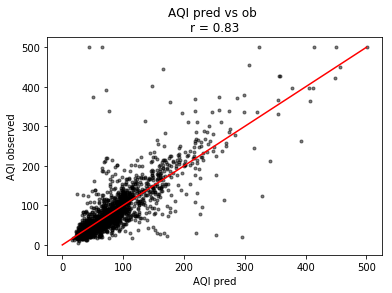

In [98]:
fig,ax = plt.subplots(1,1)
ax.scatter(y_pred_test, y_test,c = 'k', marker= '.', alpha= 0.5)
ax.plot([0,500],[0,500],'r-')
ax.set_title('AQI pred vs ob \nr = {:.2f}'.format(np.corrcoef(y_pred_test,y_test)[0,1]))
ax.set_xlabel('AQI pred')
ax.set_ylabel('AQI observed')
plt.show()

In [104]:
joblib.dump(model_aqi,'model/model_aqi1')

['model/model_aqi1']